# Fix pathing

In [1]:
import sys


sys.path.append("../..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))))


# Imports

In [3]:
import plotter
import datahandler

import matplotlib.pyplot
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display
import json
import matplotlib.pyplot as plt


# Constants

In [4]:
FOLDER_NAMES = ["ex_6_least_NSGA2", "ex_6_avg_NSGA2", "ex_6_most_NSGA2"]
FILE_INFO = {
    "ex_6_least_NSGA2": ("Lowest Activity", "green"),

    "ex_6_avg_NSGA2": ("Average Activity", "blue"),

    "ex_6_most_NSGA2": ("Highest Activity", "red"),
}

FOLDER_PATH = os.path.join(os.path.dirname(constants.PROJECT_DIRECTORY_PATH), "Simulator", "data")

DEPOTS = list(range(-1, 19))
SEEDS = list(range(5))

deep_palette = sns.color_palette("deep")
deep_colors = {
    "blue": deep_palette[0],
    "orange": deep_palette[1],
    "green": deep_palette[2],
    "red": deep_palette[3],
}

bright_palette = sns.color_palette("bright")
bright_colors = {
    "blue": bright_palette[0],
    "orange": bright_palette[1],
    "green": bright_palette[2],
    "red": bright_palette[3],
}


In [5]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(False, False, True)


Cleaning dataset: 100%|██████████| 2/2 [00:00<?, ?it/s]


Loading dataset: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


# Methods

In [6]:
def load_json():
    dataset = {}

    for folder_name in FOLDER_NAMES:
        for depot in DEPOTS:
            for seed in SEEDS:
                day, color = FILE_INFO[folder_name]

                with open(os.path.join(FOLDER_PATH, folder_name, f"heuristic_depot={depot}_seed={seed}.json"), 'r') as file:
                    dataset[(day, color, depot, seed)] = json.load(file)

    return dataset


In [7]:
def compute_metrics(dataset):
    dataframe = pd.DataFrame()

    dataframe["day"] = "None"
    dataframe["color"] = "None"
    dataframe["depot"] = 0
    dataframe["seed"] = 0
    dataframe["generation"] = 0
    dataframe["individual"] = 0
    dataframe["diversity"] = 0
    dataframe["front_number"] = np.nan
    dataframe["crowding_distance"] = np.nan
    dataframe["percentage_violations"] = 0
    dataframe["percentage_violations_urban"] = 0
    dataframe["percentage_violations_rural"] = 0
    dataframe["avg_response_time_urban_a"] = 0
    dataframe["avg_response_time_urban_h"] = 0
    dataframe["avg_response_time_urban_v1"] = 0
    dataframe["avg_response_time_rural_a"] = 0
    dataframe["avg_response_time_rural_h"] = 0
    dataframe["avg_response_time_rural_v1"] = 0

    for (day, color, depot, seed), data in dataset.items():
        generation = list(range(len(data['diversity'])))[-1]

        individuals = list(range(len(data['percentage_violations'][generation])))

        diversity = data['diversity'][generation][0]

        for individual in individuals:
            objectives = []
            objective_keys = [
                "front_number",
                "crowding_distance",
                "percentage_violations",
                "percentage_violations_urban",
                "percentage_violations_rural",
                "avg_response_time_urban_a",
                "avg_response_time_urban_h",
                "avg_response_time_urban_v1",
                "avg_response_time_rural_a",
                "avg_response_time_rural_h",
                "avg_response_time_rural_v1",
            ]

            for objective_key in objective_keys:
                if objective_key in data:
                    objective = data[objective_key][generation][individual]
                else:
                    objective = np.nan
                
                objectives.append(objective)

            # add row
            dataframe.loc[len(dataframe.index)] = [
                day,
                color,
                depot,
                seed,
                generation,
                individual,
                diversity,
                *objectives
            ]
    
    dataframe.drop_duplicates(
        subset=[
            "day",
            "depot",
            "seed",
            "generation",
            "diversity",
            "front_number",
            "percentage_violations",
            "percentage_violations_urban",
            "percentage_violations_rural",
            "avg_response_time_urban_a",
            "avg_response_time_urban_h",
            "avg_response_time_urban_v1",
            "avg_response_time_rural_a",
            "avg_response_time_rural_h",
            "avg_response_time_rural_v1",
        ],
        inplace=True
    )
    
    return dataframe


In [8]:
def load_csv(filename = "events"):
    dataframes = []
    for seed in list(range(10)):
        dataframes.append(pd.read_csv(os.path.join(FOLDER_PATH, filename + "_seed=" + str(seed) + ".csv")))
    
    dataframe = pd.concat(dataframes, ignore_index=True)

    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    dataframe['total_response_time'] = dataframe[response_time_cols].sum(axis=1)

    dataframe["complied"] = np.nan
    # Define the criteria for response times
    criteria = {
        ('A', True): 12 * 60,
        ('A', False): 25 * 60,
        ('H', True): 30 * 60,
        ('H', False): 40 * 60
    }

    for (triage, urban), group in dataframe.groupby(['triage_impression_during_call', 'urban']):
        if triage == 'V1':
            continue
    
        limit = criteria.get((triage, urban))
        if limit is not None:
            dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit

    return dataframe


In [9]:
def print_info(dataframe: pd.DataFrame):
    filtered_df = dataframe.dropna(subset=['complied'])

    # compliance
    numerator = filtered_df['complied'].count()
    true_count = filtered_df['complied'].sum()

    compliance_rate = true_count / numerator

    print(f"Compliance Rate: {(abs(compliance_rate - 1) * 100):.2f}")

    # complaince (U)
    # compliance (R)
    compliance_rates = filtered_df.groupby('urban')['complied'].agg(lambda x: x.mean())

    groups = []
    rates = []

    for group, rate in compliance_rates.items():
        groups.append(group)
        rates.append(rate)
    
    for group, rate in zip(groups[::-1], rates[::-1]):
        print(f"Compliance Rate for {'Urban' if group else 'Non-Urban'}: {(abs(rate - 1) * 100):.2f}")


# Main

In [10]:
dataset = load_json()
dataframe = compute_metrics(dataset)

dataframe.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1170 entries, 0 to 5984
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   day                          1170 non-null   object 
 1   color                        1170 non-null   object 
 2   depot                        1170 non-null   int64  
 3   seed                         1170 non-null   int64  
 4   generation                   1170 non-null   int64  
 5   individual                   1170 non-null   int64  
 6   diversity                    1170 non-null   float64
 7   front_number                 1170 non-null   int64  
 8   crowding_distance            1170 non-null   float64
 9   percentage_violations        1170 non-null   float64
 10  percentage_violations_urban  1170 non-null   float64
 11  percentage_violations_rural  1170 non-null   float64
 12  avg_response_time_urban_a    1170 non-null   float64
 13  avg_response_time_urban

In [11]:
day = "Highest Activity"
depot = 18


In [12]:
indices = []

seed = 0
filtered_df = dataframe[
    (dataframe["day"] == day) &
    (dataframe["depot"] == depot) & 
    (dataframe["seed"] == seed) & 
    (dataframe["generation"] == dataframe[(dataframe["day"] == day) & (dataframe["depot"] == depot) & (dataframe["seed"] == seed)]["generation"].max()) &
    (dataframe["front_number"] == 0)
]
indices.append(filtered_df.index[0])
IPython.display.display(filtered_df)

seed = 1
filtered_df = dataframe[
    (dataframe["day"] == day) &
    (dataframe["depot"] == depot) & 
    (dataframe["seed"] == seed) & 
    (dataframe["generation"] == dataframe[(dataframe["day"] == day) & (dataframe["depot"] == depot) & (dataframe["seed"] == seed)]["generation"].max()) &
    (dataframe["front_number"] == 0)
]
indices.append(filtered_df.index[0])
IPython.display.display(filtered_df)

seed = 2
filtered_df = dataframe[
    (dataframe["day"] == day) &
    (dataframe["depot"] == depot) & 
    (dataframe["seed"] == seed) & 
    (dataframe["generation"] == dataframe[(dataframe["day"] == day) & (dataframe["depot"] == depot) & (dataframe["seed"] == seed)]["generation"].max()) &
    (dataframe["front_number"] == 0)
]
indices.append(filtered_df.index[0])
IPython.display.display(filtered_df)

seed = 3
filtered_df = dataframe[
    (dataframe["day"] == day) &
    (dataframe["depot"] == depot) & 
    (dataframe["seed"] == seed) & 
    (dataframe["generation"] == dataframe[(dataframe["day"] == day) & (dataframe["depot"] == depot) & (dataframe["seed"] == seed)]["generation"].max()) &
    (dataframe["front_number"] == 0)
]
indices.append(filtered_df.index[0])
IPython.display.display(filtered_df)

seed = 4
filtered_df = dataframe[
    (dataframe["day"] == day) &
    (dataframe["depot"] == depot) & 
    (dataframe["seed"] == seed) & 
    (dataframe["generation"] == dataframe[(dataframe["day"] == day) & (dataframe["depot"] == depot) & (dataframe["seed"] == seed)]["generation"].max()) &
    (dataframe["front_number"] == 0)
]
indices.append(filtered_df.index[0])
IPython.display.display(filtered_df)

print(indices)


,day,color,depot,seed,generation,individual,diversity,front_number,crowding_distance,percentage_violations,percentage_violations_urban,percentage_violations_rural,avg_response_time_urban_a,avg_response_time_urban_h,avg_response_time_urban_v1,avg_response_time_rural_a,avg_response_time_rural_h,avg_response_time_rural_v1
5900,Highest Activity,red,18,0,68,0,0.15,0,1.797690e+308,0.180328,0.19375,0.086957,651.986,1240.43,3701.29,981.267,1474.50,4957.25
5902,Highest Activity,red,18,0,68,2,0.15,0,1.797690e+308,0.174863,0.20000,0.000000,630.324,1228.50,3772.15,878.667,1481.50,4687.25
5908,Highest Activity,red,18,0,68,8,0.15,0,0.000000e+00,0.180328,0.19375,0.086957,658.014,1213.49,3773.27,978.000,1688.75,6344.62


,day,color,depot,seed,generation,individual,diversity,front_number,crowding_distance,percentage_violations,percentage_violations_urban,percentage_violations_rural,avg_response_time_urban_a,avg_response_time_urban_h,avg_response_time_urban_v1,avg_response_time_rural_a,avg_response_time_rural_h,avg_response_time_rural_v1
5920,Highest Activity,red,18,1,63,0,0.55,0,1.797690e+308,0.185792,0.19375,0.130435,630.973,1189.66,3531.40,930.333,1691.62,3412.25
5922,Highest Activity,red,18,1,63,2,0.55,0,1.797690e+308,0.185792,0.21250,0.000000,640.122,1183.90,3660.61,943.067,1325.50,3330.38
5927,Highest Activity,red,18,1,63,7,0.55,0,0.000000e+00,0.185792,0.21250,0.000000,640.122,1184.23,3660.61,943.067,1325.50,3330.38


,day,color,depot,seed,generation,individual,diversity,front_number,crowding_distance,percentage_violations,percentage_violations_urban,percentage_violations_rural,avg_response_time_urban_a,avg_response_time_urban_h,avg_response_time_urban_v1,avg_response_time_rural_a,avg_response_time_rural_h,avg_response_time_rural_v1
5940,Highest Activity,red,18,2,41,0,0.65,0,1.797690e+308,0.191257,0.20625,0.086957,626.027,1219.98,3587.73,1017.130,1227.62,3909.00
5943,Highest Activity,red,18,2,41,3,0.65,0,2.000000e+00,0.191257,0.21250,0.043478,666.000,1272.57,3661.49,958.667,1171.50,3646.25
5944,Highest Activity,red,18,2,41,4,0.65,0,1.797690e+308,0.196721,0.22500,0.000000,650.757,1293.24,3706.49,932.267,1219.00,4325.88


,day,color,depot,seed,generation,individual,diversity,front_number,crowding_distance,percentage_violations,percentage_violations_urban,percentage_violations_rural,avg_response_time_urban_a,avg_response_time_urban_h,avg_response_time_urban_v1,avg_response_time_rural_a,avg_response_time_rural_h,avg_response_time_rural_v1
5960,Highest Activity,red,18,3,72,0,0.4,0,1.797690e+308,0.207650,0.20625,0.217391,630.135,1295.57,3482.05,1067.330,1666.25,3841.00
5965,Highest Activity,red,18,3,72,5,0.4,0,4.852940e-01,0.202186,0.21250,0.130435,663.095,1239.19,3808.34,1032.400,1711.38,4724.62
5967,Highest Activity,red,18,3,72,7,0.4,0,1.797690e+308,0.191257,0.21875,0.000000,644.514,1238.93,3845.13,839.267,1459.62,5098.12


,day,color,depot,seed,generation,individual,diversity,front_number,crowding_distance,percentage_violations,percentage_violations_urban,percentage_violations_rural,avg_response_time_urban_a,avg_response_time_urban_h,avg_response_time_urban_v1,avg_response_time_rural_a,avg_response_time_rural_h,avg_response_time_rural_v1
5980,Highest Activity,red,18,4,76,0,0.2,0,1.797690e+308,0.163934,0.16875,0.130435,650.946,1130.30,3579.50,989.600,1583.00,4270.50
5982,Highest Activity,red,18,4,76,2,0.2,0,1.797690e+308,0.174863,0.20000,0.000000,639.135,1189.59,3609.99,907.733,1212.12,3361.25
5983,Highest Activity,red,18,4,76,3,0.2,0,1.797690e+308,0.174863,0.20000,0.000000,629.149,1190.23,3606.21,910.333,1214.62,3371.88
5984,Highest Activity,red,18,4,76,4,0.2,0,1.441380e+00,0.163934,0.18125,0.043478,616.770,1180.22,3622.94,969.933,1560.00,3756.75


[5900, 5920, 5940, 5960, 5980]


In [13]:
best_individuals_indices_lowest = [
    [2, 22, 40, 62, 80], # -1
    
    [102, 122, 142, 179, 198], #  0
    [204, 220, 240, 262, 281], #  1
    [300, 322, 347, 360, 382], #  2
    [400, 420, 440, 460, 480], #  3
    [502, 522, 542, 560, 582], #  4
    [618, 622, 658, 662, 682], #  5
    [702, 721, 742, 760, 780], #  6
    [803, 821, 840, 873, 882], #  7
    [900, 922, 942, 962, 982], #  8
    [1000, 1038, 1042, 1060, 1098], #  9
    [1100, 1122, 1142, 1160, 1180], # 10
    [1218, 1222, 1258, 1260, 1282], # 11
    [1300, 1322, 1342, 1362, 1380], # 12
    [1402, 1422, 1442, 1462, 1482], # 13
    [1518, 1538, 1542, 1562, 1598], # 14 (strange results)
    [1602, 1620, 1640, 1662, 1682], # 15
    [1700, 1720, 1740, 1761, 1780], # 16
    [1800, 1820, 1842, 1862, 1880], # 17
    [1900, 1922, 1942, 1962, 1998], # 18
]


In [14]:
best_individuals_indices_average = [
    [2000, 2020, 2040, 2060, 2080], # -1
    
    [2100, 2120, 2140, 2160, 2180], #  0
    [2200, 2220, 2240, 2260, 2280], #  1
    [2300, 2320, 2340, 2360, 2380], #  2
    [2400, 2420, 2440, 2460, 2480], #  3
    [2500, 2520, 2540, 2560, 2580], #  4
    [2600, 2620, 2640, 2660, 2680], #  5
    [2700, 2720, 2740, 2760, 2780], #  6
    [2800, 2820, 2840, 2860, 2880], #  7
    [2900, 2920, 2940, 2960, 2980], #  8
    [3000, 3020, 3040, 3060, 3080], #  9
    [3100, 3120, 3140, 3160, 3180], # 10
    [3200, 3220, 3240, 3260, 3280], # 11
    [3300, 3320, 3340, 3360, 3380], # 12
    [3400, 3420, 3440, 3460, 3480], # 13
    [3500, 3520, 3540, 3560, 3580], # 14
    [3600, 3620, 3640, 3660, 3680], # 15
    [3700, 3720, 3740, 3760, 3780], # 16
    [3800, 3820, 3840, 3860, 3880], # 17
    [3900, 3920, 3940, 3960, 3980], # 18
]


In [15]:
best_individuals_indices_highest = [ # hard to pick best, might have to revisit.
    [4012, 4034, 4040, 4067, 4080], # -1
    
    [4100, 4120, 4140, 4161, 4182], #  0
    [4200, 4220, 4240, 4260, 4280], #  1
    [4300, 4320, 4344, 4360, 4385], #  2
    [4400, 4420, 4440, 4460, 4480], #  3
    [4500, 4520, 4540, 4560, 4582], #  4
    [4600, 4620, 4652, 4671, 4680], #  5
    [4704, 4723, 4745, 4760, 4780], #  6
    [4800, 4820, 4840, 4860, 4880], #  7
    [4900, 4920, 4942, 4960, 4980], #  8
    [5000, 5020, 5044, 5060, 5080], #  9
    [5100, 5120, 5140, 5164, 5180], # 10
    [5200, 5224, 5240, 5260, 5280], # 11
    [5302, 5320, 5340, 5363, 5380], # 12
    [5400, 5434, 5440, 5460, 5480], # 13
    [5503, 5520, 5557, 5564, 5593], # 14
    [5600, 5620, 5640, 5660, 5680], # 15
    [5700, 5720, 5742, 5776, 5780], # 16
    [5800, 5820, 5840, 5860, 5880], # 17 (ser ut til å bare gi ett resultat for alle dagene (konvergerer den raskt uten denne stasjonen?))
    [5900, 5920, 5940, 5967, 5980], # 18
]

In [28]:
# DataFrame of best individuals from each seed
best_individuals_df = dataframe.loc[best_individuals_indices_highest[0]]

IPython.display.display(best_individuals_df)

# Find the overall best individual across all seeds
overall_best_individual = best_individuals_df.loc[4040]
overall_best_seed = overall_best_individual["seed"]
overall_best_fitness = overall_best_individual["percentage_violations"]
overall_best_vio_urban = overall_best_individual["percentage_violations_urban"]
overall_best_vio_rural = overall_best_individual["percentage_violations_rural"]
overall_best_individual_generations = overall_best_individual["generation"]

# Total amount of generations: count all unique generation numbers across all seeds
total_generations = filtered_df["generation"].nunique()
std_dev_fitness = best_individuals_df["percentage_violations"].std()

# Average fitness and average number of generations per seed
average_fitness_per_seed = best_individuals_df["percentage_violations"].mean()
average_generations_per_seed = best_individuals_df["generation"].mean()

print("Overall Best: Seed:", overall_best_seed)
print("Overall Best: Fitness:", overall_best_fitness)
print("Overall Best: Vio Urban:", overall_best_vio_urban)
print("Overall Best: Vio Rural:", overall_best_vio_rural)
print("Overall Best: Total Generations:", total_generations)
print("Average Fitness per Seed:", average_fitness_per_seed)
print("Average Generations per Seed:", average_generations_per_seed)
print("Standard Deviation of Fitness:", std_dev_fitness)


,day,color,depot,seed,generation,individual,diversity,front_number,crowding_distance,percentage_violations,percentage_violations_urban,percentage_violations_rural,avg_response_time_urban_a,avg_response_time_urban_h,avg_response_time_urban_v1,avg_response_time_rural_a,avg_response_time_rural_h,avg_response_time_rural_v1
4012,Highest Activity,red,-1,0,54,12,0.35,0,2.000000e+00,0.169399,0.18750,0.043478,650.108,1243.56,3794.39,988.667,1670.50,4785.00
4034,Highest Activity,red,-1,1,68,14,0.20,0,3.838100e-01,0.163934,0.17500,0.086957,609.027,1181.06,3787.32,892.467,1489.38,5153.38
4040,Highest Activity,red,-1,2,54,0,0.05,0,1.797690e+308,0.142077,0.16250,0.000000,626.500,1120.78,3507.43,885.533,1516.50,4111.62
4067,Highest Activity,red,-1,3,71,7,0.30,0,6.444440e-01,0.169399,0.18750,0.043478,650.662,1200.48,3718.05,986.400,1439.38,4012.38
4080,Highest Activity,red,-1,4,52,0,0.25,0,1.797690e+308,0.163934,0.18125,0.043478,646.730,1163.87,3342.66,902.933,1699.00,4987.88


Overall Best: Seed: 2
Overall Best: Fitness: 0.142077
Overall Best: Vio Urban: 0.1625
Overall Best: Vio Rural: 0.0
Overall Best: Total Generations: 1
Average Fitness per Seed: 0.1617486
Average Generations per Seed: 59.8
Standard Deviation of Fitness: 0.01133116314859158


In [31]:
y_urban_lowest = []
y_urban_average = []
y_urban_highest = []
y_urban_all = []

y_rural_lowest = []
y_rural_average = []
y_rural_highest = []
y_rural_all = []

for depot_index in list(range(19)):
    print(f"Depot removed {data_loader.enhanced_depots_df['name'].loc[depot_index]} ({data_loader.enhanced_depots_df['region'].loc[depot_index]}):")
    
    baseline_compliance_average = 0
    baseline_compliance_urban_average = 0
    baseline_compliance_rural_average = 0

    depot_compliance_average = 0
    depot_compliance_urban_average = 0
    depot_compliance_rural_average = 0

    for day in ["Lowest Activity", "Average Activity", "Highest Activity"]:
        print (f"\t{day}:")

        # get baseline data
        if day == "Lowest Activity":
            subset_baseline = dataframe.loc[best_individuals_indices_lowest[0]]
        elif day == "Average Activity":
            subset_baseline = dataframe.loc[best_individuals_indices_average[0]]
        else:
            subset_baseline = dataframe.loc[best_individuals_indices_highest[0]]
        
        baseline_compliance = (subset_baseline["percentage_violations"].mean() - 1) * -100
        baseline_compliance_average += baseline_compliance
        baseline_compliance_urban = (subset_baseline["percentage_violations_urban"].mean() - 1) * -100
        baseline_compliance_urban_average += baseline_compliance_urban
        baseline_compliance_rural = (subset_baseline["percentage_violations_rural"].mean() - 1) * -100
        baseline_compliance_rural_average += baseline_compliance_rural

        # get depot data
        if day == "Lowest Activity":
            subset_depot = dataframe.loc[best_individuals_indices_lowest[depot_index + 1]]
        elif day == "Average Activity":
            subset_depot = dataframe.loc[best_individuals_indices_average[depot_index + 1]]
        else:
            subset_depot = dataframe.loc[best_individuals_indices_highest[depot_index + 1]]

        depot_compliance = (subset_depot["percentage_violations"].mean() - 1) * -100
        depot_compliance_average += depot_compliance
        depot_compliance_urban = (subset_depot["percentage_violations_urban"].mean() - 1) * -100
        depot_compliance_urban_average += depot_compliance_urban
        depot_compliance_rural = (subset_depot["percentage_violations_rural"].mean() - 1) * -100
        depot_compliance_rural_average += depot_compliance_rural

        difference = depot_compliance - baseline_compliance
        difference_urban = depot_compliance_urban - baseline_compliance_urban
        difference_rural = depot_compliance_rural - baseline_compliance_rural

        if day == "Lowest Activity":
            y_urban_lowest.append(difference_urban)
            y_rural_lowest.append(difference_rural)
        elif day == "Average Activity":
            y_urban_average.append(difference_urban)
            y_rural_average.append(difference_rural)
        else:
            y_urban_highest.append(difference_urban)
            y_rural_highest.append(difference_rural)

        print(f"\t\tCompliance:       {depot_compliance:.2f}%, Difference: {difference:.2f}%")
        print(f"\t\tCompliance Urban: {depot_compliance_urban:.2f}%, Difference: {difference_urban:.2f}%")
        print(f"\t\tCompliance Rural: {depot_compliance_rural:.2f}%, Difference: {difference_rural:.2f}%")
        print()
    
    difference = (depot_compliance_average - baseline_compliance_average) / 3
    difference_urban = (depot_compliance_urban_average - baseline_compliance_urban_average) / 3
    difference_rural = (depot_compliance_rural_average - baseline_compliance_rural_average) / 3

    y_urban_all.append(difference_urban)
    y_rural_all.append(difference_rural)
        
    print (f"\tAll:")
    print(f"\t\tCompliance:       {(depot_compliance_average / 3):.2f}%, Difference: {difference:.2f}%")
    print(f"\t\tCompliance Urban: {(depot_compliance_urban_average / 3):.2f}%, Difference: {difference_urban:.2f}%")
    print(f"\t\tCompliance Rural: {(depot_compliance_rural_average / 3):.2f}%, Difference: {difference_rural:.2f}%")
    print()

subset_baseline_lowest = dataframe.loc[best_individuals_indices_lowest[0]]
subset_baseline_average = dataframe.loc[best_individuals_indices_average[0]]
subset_baseline_highest = dataframe.loc[best_individuals_indices_highest[0]]

print (f"Mean baseline:")
print(f"\tCompliance:       {((((subset_baseline_lowest['percentage_violations'].mean() + subset_baseline_average['percentage_violations'].mean() + subset_baseline_highest['percentage_violations'].mean()) / 3) - 1) * -100):.2f}%%")
print(f"\tCompliance Urban: {((((subset_baseline_lowest['percentage_violations_urban'].mean() + subset_baseline_average['percentage_violations_urban'].mean() + subset_baseline_highest['percentage_violations_urban'].mean()) / 3) - 1) * -100):.2f}%")
print(f"\tCompliance Rural: {((((subset_baseline_lowest['percentage_violations_rural'].mean() + subset_baseline_average['percentage_violations_rural'].mean() + subset_baseline_highest['percentage_violations_rural'].mean()) / 3) - 1) * -100):.2f}%")
print()



Depot removed Eidsvoll (Akershus):
	Lowest Activity:
		Compliance:       91.14%, Difference: -2.42%
		Compliance Urban: 91.16%, Difference: -2.61%
		Compliance Rural: 90.91%, Difference: 0.00%

	Average Activity:
		Compliance:       90.61%, Difference: -1.34%
		Compliance Urban: 90.77%, Difference: -0.77%
		Compliance Rural: 87.50%, Difference: -12.50%

	Highest Activity:
		Compliance:       82.95%, Difference: -0.87%
		Compliance Urban: 81.50%, Difference: -0.62%
		Compliance Rural: 93.04%, Difference: -2.61%

	All:
		Compliance:       88.23%, Difference: -1.54%
		Compliance Urban: 87.81%, Difference: -1.33%
		Compliance Rural: 90.48%, Difference: -5.04%

Depot removed Ullensaker (Akershus):
	Lowest Activity:
		Compliance:       92.35%, Difference: -1.21%
		Compliance Urban: 93.04%, Difference: -0.72%
		Compliance Rural: 83.64%, Difference: -7.27%

	Average Activity:
		Compliance:       90.61%, Difference: -1.34%
		Compliance Urban: 90.13%, Difference: -1.41%
		Compliance Rural: 100.0

In [18]:
x_values = [data_loader.enhanced_depots_df['name'].loc[depot_index] for depot_index in list(range(19))]

color_urban = sns.color_palette("Paired")[1]
color_rural = sns.color_palette("Paired")[3]


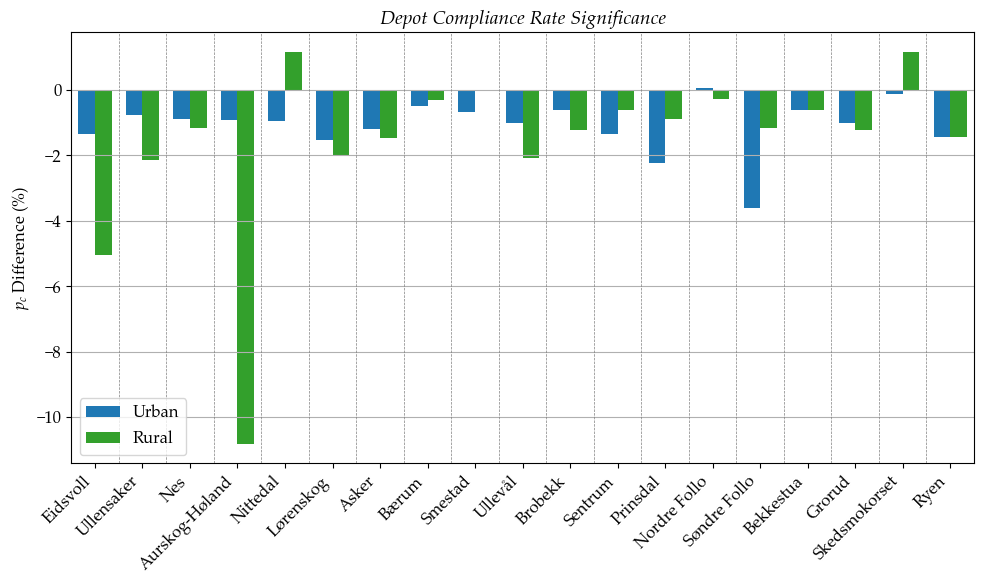

In [19]:
y_values_urban = y_urban_all
y_values_rural = y_rural_all

x = np.arange(len(x_values))  # the label locations
width = 0.35  # the width of the bars

# Create bars and specify figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size here
rects1 = ax.bar(x - width/2, y_values_urban, width, label='Urban', color=color_urban)
rects2 = ax.bar(x + width/2, y_values_rural, width, label='Rural', color=color_rural)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$p_c$ Difference (%)')
title = 'Depot Compliance Rate Significance'
ax.set_title(title, fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
ax.set_xticks(x)
ax.set_xticklabels(x_values, rotation=45, ha='right')  # Rotate the x-axis labels to 45 degrees
ax.set_xlim((-0.5, 18.5))
ax.grid(axis='y')
ax.legend()

mid_points = x[:-1] + 0.5

# Draw vertical grid lines at these positions
for pos in mid_points:
    ax.axvline(pos, color='grey', linestyle='--', linewidth=0.5)

# Improve layout to prevent clipping of tick-labels
plt.tight_layout()

plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title + ".png"), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


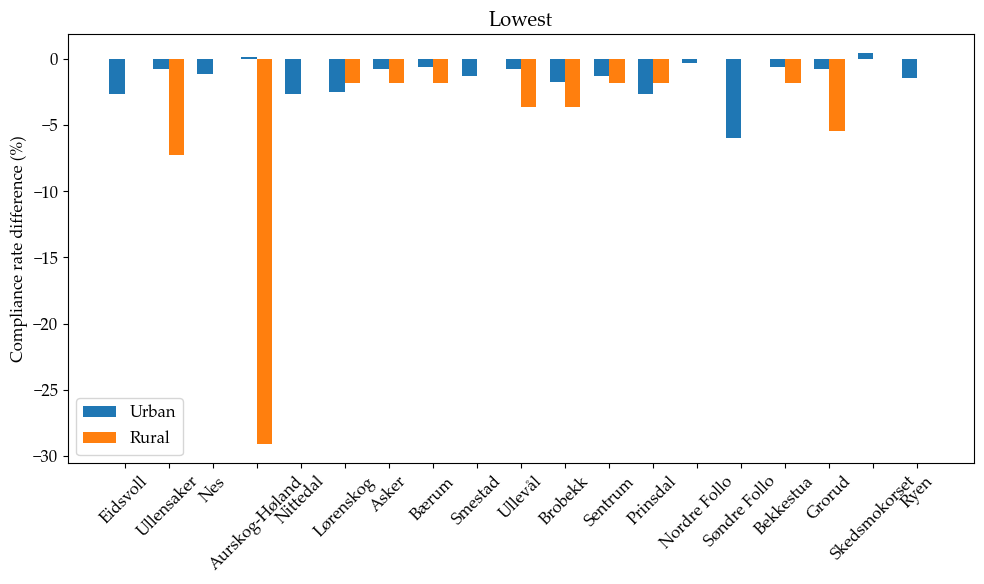

In [20]:
y_values_urban = y_urban_lowest
y_values_rural = y_rural_lowest

x = np.arange(len(x_values))  # the label locations
width = 0.35  # the width of the bars

# Create bars and specify figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size here
rects1 = ax.bar(x - width/2, y_values_urban, width, label='Urban')
rects2 = ax.bar(x + width/2, y_values_rural, width, label='Rural')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Compliance rate difference (%)')
ax.set_title('Lowest')
ax.set_xticks(x)
ax.set_xticklabels(x_values, rotation=45)  # Rotate the x-axis labels to 45 degrees
ax.legend()

# Improve layout to prevent clipping of tick-labels
plt.tight_layout()

# Show the plot
plt.show()


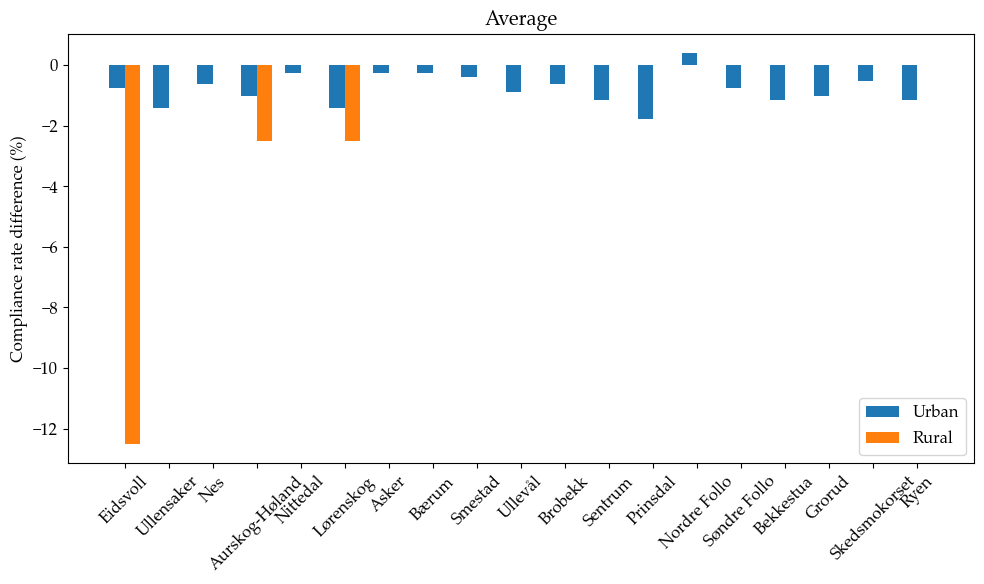

In [21]:
y_values_urban = y_urban_average
y_values_rural = y_rural_average

x = np.arange(len(x_values))  # the label locations
width = 0.35  # the width of the bars

# Create bars and specify figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size here
rects1 = ax.bar(x - width/2, y_values_urban, width, label='Urban')
rects2 = ax.bar(x + width/2, y_values_rural, width, label='Rural')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Compliance rate difference (%)')
ax.set_title('Average')
ax.set_xticks(x)
ax.set_xticklabels(x_values, rotation=45)  # Rotate the x-axis labels to 45 degrees
ax.legend()

# Improve layout to prevent clipping of tick-labels
plt.tight_layout()

# Show the plot
plt.show()


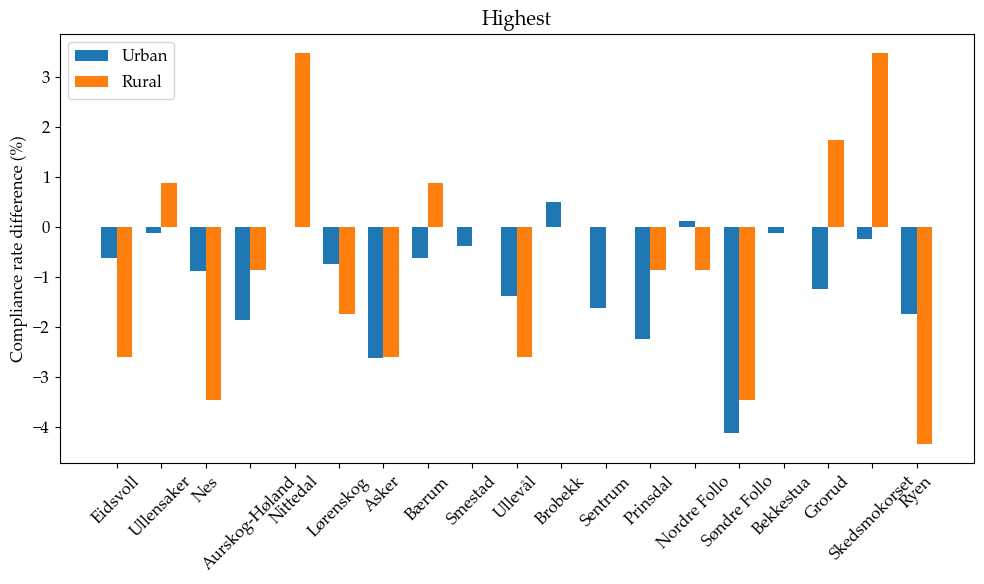

In [22]:
y_values_urban = y_urban_highest
y_values_rural = y_rural_highest

x = np.arange(len(x_values))  # the label locations
width = 0.35  # the width of the bars

# Create bars and specify figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size here
rects1 = ax.bar(x - width/2, y_values_urban, width, label='Urban')
rects2 = ax.bar(x + width/2, y_values_rural, width, label='Rural')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Compliance rate difference (%)')
ax.set_title('Highest')
ax.set_xticks(x)
ax.set_xticklabels(x_values, rotation=45)  # Rotate the x-axis labels to 45 degrees
ax.legend()

# Improve layout to prevent clipping of tick-labels
plt.tight_layout()

# Show the plot
plt.show()
